In [ ]:
!pip install vncorenlp
!pip install transformers==4.8.2
!pip install emoji
!pip install sentence_transformers

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
!nvidia-smi

Tue Oct  5 11:32:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/VLSP-Fake-News-Detection/public_train.csv"
test_path = "/content/drive/MyDrive/VLSP-Fake-News-Detection/final_private_test.csv"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle, os, re, json
import statistics
import matplotlib.pyplot as plt
import torch
import statsmodels.api as sm

from vncorenlp import VnCoreNLP
from nltk.tokenize import TweetTokenizer
from scipy.stats import zscore
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from collections import *
from datetime import datetime
from transformers import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from transformers import logging
from lightgbm import LGBMClassifier, LGBMModel
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from pandas import DataFrame
from pandas._libs.missing import NAType

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_train = pd.read_csv(train_path, encoding="utf-8")
data_test = pd.read_csv(test_path, encoding="utf-8")

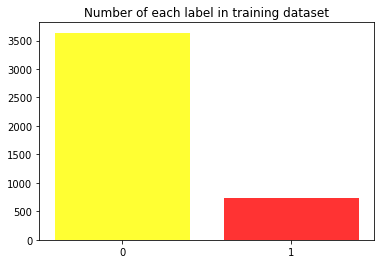

In [ ]:
#Training dataset
# data_train = data_train.replace({'label':{0: 'reliable', 1:'unreliable'}})
figures = data_train['label'].value_counts().to_frame()

labels = figures.index.to_list()
labels_counts = figures['label'].to_list()
plt.figure()
plt.bar(range(len(labels_counts)), labels_counts, color = ['yellow', 'red'], alpha = .8)
#Visualize number of each unique label
plt.xticks(range(len(labels_counts)), labels)
plt.title('Number of each label in training dataset')
plt.show()

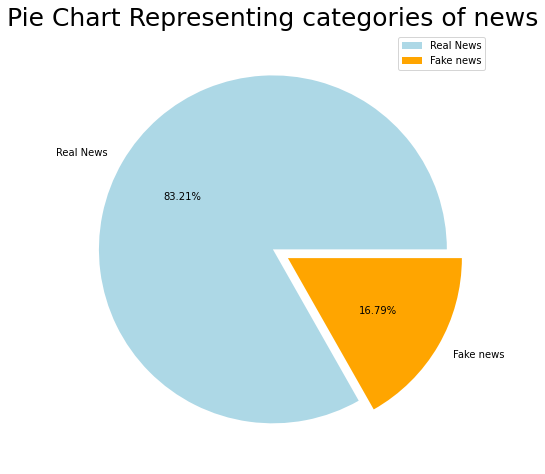

In [ ]:
num_real = data_train['label'].value_counts()[0]
num_fakes = data_train['label'].value_counts()[1]

size = [num_real, num_fakes]
colors = ['lightblue', 'orange']
labels_piechart = "Real News", "Fake news"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, labels = labels_piechart, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representing categories of news', fontsize = 25)
plt.legend()
plt.show()

In [ ]:
#Time stamp feature
data_train['timestamp_post'] = pd.to_numeric(data_train['timestamp_post'], errors='coerce')
data_train['timestamp_post'] = data_train['timestamp_post'].astype('Int64')

data_test['timestamp_post'] = pd.to_numeric(data_test['timestamp_post'], errors='coerce')
data_test['timestamp_post'] = data_test['timestamp_post'].astype('Int64')

#Number of shares feature
data_train['num_share_post'] = pd.to_numeric(data_train['num_share_post'], errors='coerce')
data_train['num_share_post'] = data_train['num_share_post'].astype('Int64')
data_test['num_share_post'] = pd.to_numeric(data_test['num_share_post'], errors='coerce')
data_test['num_share_post'] = data_test['num_share_post'].astype('Int64')

#Number of likes feature
data_train['num_like_post'] = pd.to_numeric(data_train['num_like_post'], errors='coerce')
data_train['num_like_post'] = data_train['num_like_post'].astype('Int64')
data_test['num_like_post'] = pd.to_numeric(data_test['num_like_post'], errors='coerce')
data_test['num_like_post'] = data_test['num_like_post'].astype('Int64')

#Number of comments feature
data_train['num_comment_post'] = pd.to_numeric(data_train['num_comment_post'], errors='coerce')
data_train['num_comment_post'] = data_train['num_comment_post'].astype('Int64')
data_test['num_comment_post'] = pd.to_numeric(data_test['num_comment_post'], errors='coerce')
data_test['num_comment_post'] = data_test['num_comment_post'].astype('Int64')

In [ ]:
data_train['post_message'] = data_train['post_message'].fillna('empty')

In [ ]:
timestamp_lst = data_train['timestamp_post']
likes_lst = data_train['num_like_post']
comment_lst = data_train['num_comment_post']
share_lst = data_train['num_share_post']

test_timestamp_lst = data_test['timestamp_post']
test_likes_lst = data_test['num_like_post']
test_comment_lst = data_test['num_comment_post']
test_share_lst = data_test['num_share_post']

In [ ]:
nan_timestamp_idxs = []
nan_like_idxs = []
nan_comment_idxs = []
nan_share_idxs = []

for idx, ts in enumerate(timestamp_lst):
  if type(ts) == NAType:
    nan_timestamp_idxs.append(idx)

for idx, like in enumerate(likes_lst):
  if type(like) == NAType:
    nan_like_idxs.append(idx)

for idx, cmt in enumerate(comment_lst):
  if type(cmt) == NAType:
    nan_comment_idxs.append(idx)

for idx, sh in enumerate(share_lst):
  if type(sh) == NAType:
    nan_share_idxs.append(idx)

In [ ]:
test_nan_timestamp_idxs = []
test_nan_like_idxs = []
test_nan_comment_idxs = []
test_nan_share_idxs = []

for idx, ts in enumerate(test_timestamp_lst):
  if type(ts) == NAType:
    test_nan_timestamp_idxs.append(idx)

for idx, like in enumerate(test_likes_lst):
  if type(like) == NAType:
    test_nan_like_idxs.append(idx)

for idx, cmt in enumerate(test_comment_lst):
  if type(cmt) == NAType:
    test_nan_comment_idxs.append(idx)
for idx, sh in enumerate(test_share_lst):
  if type(sh) == NAType:
    test_nan_share_idxs.append(idx)

In [ ]:
f = open("/content/drive/MyDrive/ReINTEL/vietnamese-stopwords.txt", "r")
vnmese_stopwords = []
for word in f.readlines():
  word = word.replace("\n", "")
  vnmese_stopwords.append(word)

print(vnmese_stopwords)

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bao nả', 'bay biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết chắc', 'biết chừng nào', 'biết mình', 'biết mấy', 'biết thế', 'biết trước', 'biết việc', 'biết đâu', 'biết đâu chừng', 'biết đâu đấy', 'biết được', 'buổi', 'buổi làm', 'buổi mới', 'buổi ngày', 'buổi sớm', 'bà', 'bà ấy', 'bài', 'bài bác', 'bài bỏ', 'bài cái', 'bác', 'bán', 'bán cấp', 'bán dạ', 'bán thế', 'bây bẩy', 'bây chừ', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bên bị', 'bên có', 'bên cạnh', 'bông', 'bước', 'bước khỏi', 'bước tới', 'bước đi', 'bạn', 'bản', 'bản bộ', 'bản riêng', 'bản thân', 'bản ý', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất quá chỉ', 'bất thình lình', 'bất tử', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâ

In [ ]:
def isnan(s):
    return s != s


def normalizePost(post, tweet_tokenizer, vncorenlp, use_segment=False, remove_punc_stopword=False, lowercase_opt=False, truncation_method="head_only", length=512):
    post = post.strip()
    URL_pattern = r"(?:http?s://|www.)[^\"]+"
    hashtag_pattern = r"#\s?\w+"

    post = re.sub(URL_pattern, "link", post)
    post = re.sub(hashtag_pattern, "hashtag", post)
    post = re.sub('\.+','.', post)
    if lowercase_opt:
      post = post.lower()
    tokens = tweet_tokenizer.tokenize(post.replace("’", "'").replace("…", "..."))
    
    post = " ".join(tokens)
    if use_segment:
        tokens = vncorenlp.tokenize(post.replace("’", "'").replace("…", "..."))
        tokens = [t for ts in tokens for t in ts]
    normPost = " ".join(tokens)

    if remove_punc_stopword:
      tokens = [t for t in normPost if not t in vnmese_stopwords]
    normPost = " ".join(tokens)

    normPost = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normPost)
    normPost = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normPost)
    normPost = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normPost)
    if use_segment:
        normPost = normPost.replace('< url >', '<url>')
        normPost = re.sub(r"# (\w+)", r'#\1', normPost)
    if truncation_method == "head_only":
      normPost = " ".join(normPost.split(" ")[:length])
    if truncation_method == "tail_only":
      normPost = " ".join(normPost.split(" ")[-length:])
    if truncation_method == "head_tail":
      normPost = " ".join(normPost.split(" ")[:int(length*0.25)]) + " " +  " ".join(normPost.split(" ")[-int(length*0.75):])
    return normPost

In [ ]:
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/VLSP-Fake-News-Detection/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg")
tweet_tokenizer = TweetTokenizer()

In [ ]:
sentences = data_train['post_message'].tolist()
sents = []
test_sents = []

for post in data_train.post_message:
  sents.append(normalizePost(post, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only", 512))

for test_post in data_test.post_message:
  test_sents.append(normalizePost(test_post, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only", 512))

In [ ]:
sents

['THĂNG CẤP_BẬC HÀM ĐỐI_VỚI 2 CÁN_BỘ , CHIẾN_SỸ HY_SINH Ở ĐÀ_NẴNG Ngày 3/4 , Đại_tướng Tô_Lâm , Bộ_trưởng Bộ Công_an đã ký quyết_định số 2398 / QĐ-BCA-X 01 thăng cấp_bậc hàm từ Đại_uý lên Thiếu_tá đối_với đồng_chí Đặng_Thanh_Tuấn . Cùng ngày , Thiếu_tướng Vũ_Xuân_Viên , Giám_đốc Công_an thành_phố Đà_Nẵng ký Quyết_định số 479 / QĐ-CATP thăng cấp_bậc hàm từ Trung_sĩ lên thượng_sỹ đối_với đồng_chí Võ_Văn_Toàn . Đây là 2 cán_bộ , chiến_sỹ đã hy_sinh trong quá_trình thực_hiện nhiệm_vụ đảm_bảo an_ninh , trật_tự , phòng , chống tội_phạm trên địa_bàn thành_phố Đà_Nẵng . Trước đó , vào lúc 20h40 ngày 2/4/2020 , Công_an TP . Đà_Nẵng nhận được tin báo của nhân_dân có nhóm đối_tượng đua xe và cướp_giật người đi đường tại khu_vực quận Sơn_Trà , trong bối_cảnh toàn_quốc thực_hiện cách_ly xã_hội theo Chỉ_thị số 16 của Thủ_tướng Chính_phủ . Công_an TP . Đà_Nẵng đã chỉ_đạo cho Công_an quận Sơn_Trà triển_khai lực_lượng truy bắt nhóm đối_tượng . Trong quá_trình truy_đuổi các đối_tượng trên , Đại_uý Đặng_

In [ ]:
from sentence_transformers import SentenceTransformer
sent_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
sen_embeddings = sent_model.encode(sents)
test_sen_embeddings = sent_model.encode(test_sents)
print(sen_embeddings.shape)

(4372, 768)


In [ ]:
def plot_wordcloud(text):
  wordclouds = WordCloud(background_color = 'black',
                         max_words = 10000,
                         width=1600,
                         height=800).generate(text)
  plt.clf()
  plt.imshow(wordclouds, interpolation='bilinear')
  plt.axis('off')
  plt.show()

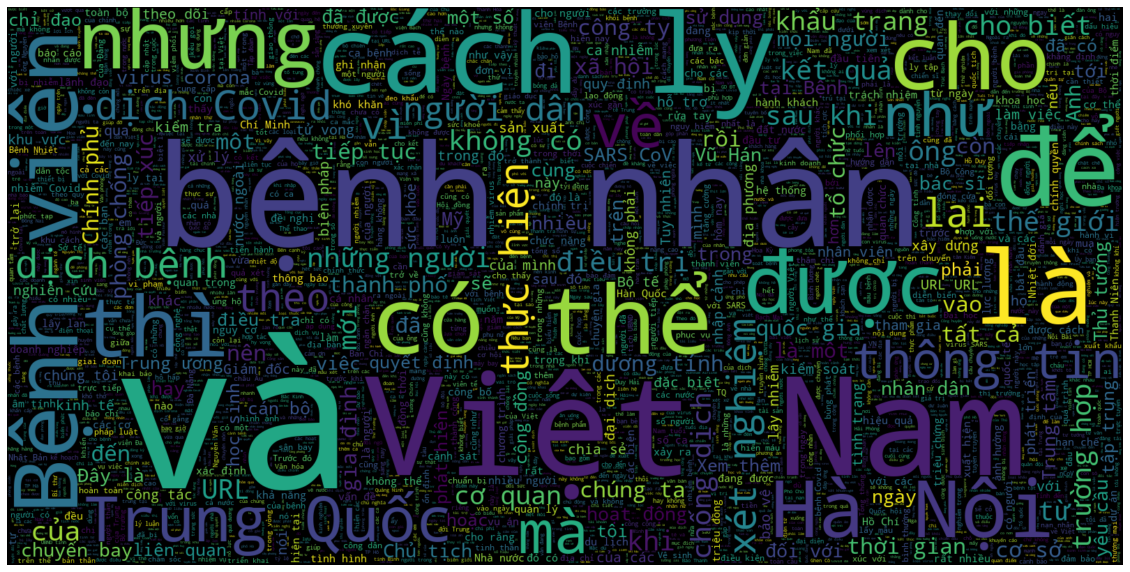

In [ ]:
plt.figure(figsize=(20,15))
plt.title("General word cloud for all news posts")
plot_wordcloud(' '.join(sentences))

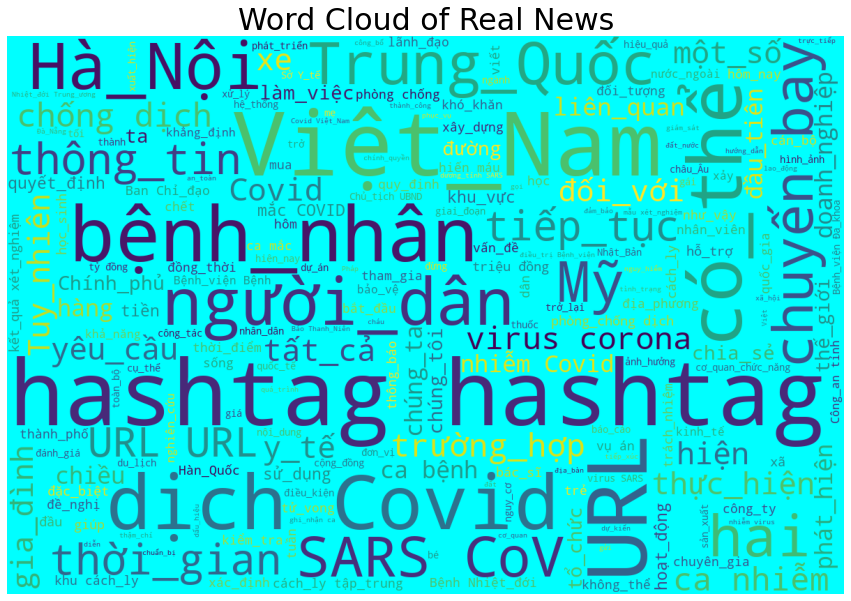

In [ ]:
real_list = data_train['post_message'][data_train['label'] == 0]
real_words = " ".join([normalizePost(text, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only") for text in real_list])
stopwords = set(vnmese_stopwords)

wordcloud = WordCloud(background_color = 'cyan', stopwords = stopwords, width = 1200, height = 800).generate(real_words)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Real News', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

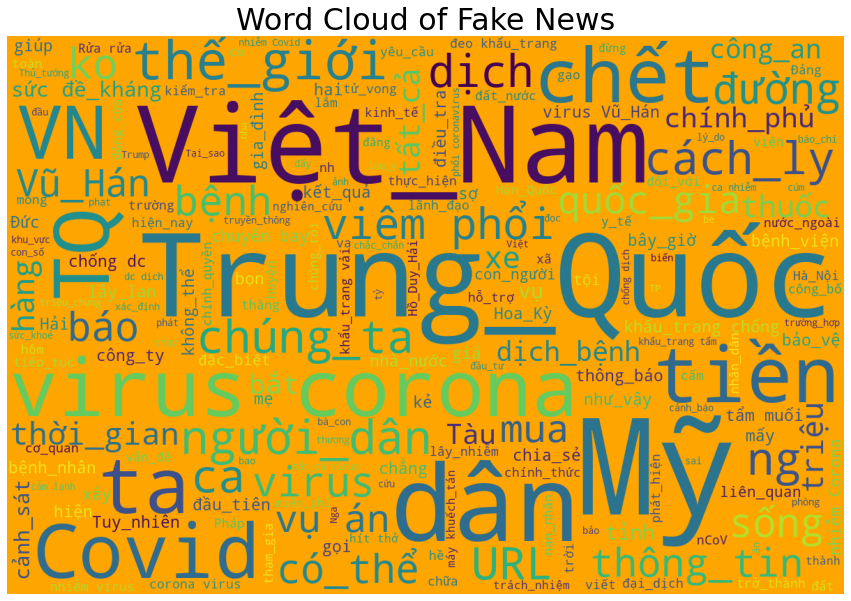

In [ ]:
fake_list = data_train['post_message'][data_train['label'] == 1]
fake_words = " ".join([normalizePost(text, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only") for text in fake_list])
stopwords = set(vnmese_stopwords)

wordcloud = WordCloud(background_color = 'orange', stopwords = stopwords, width = 1200, height = 800).generate(fake_words)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Fake News', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
pairwise_similarities=cosine_similarity(sen_embeddings)
test_pairwise_similarities = cosine_similarity(test_sen_embeddings)

In [ ]:
def fill_missing(df, pairwise_similarity, feature, features_list):
  for i in features_list:
    max_val, pos_i, pos_j = -1, -1, -1
    for j in range(len(pairwise_similarity[i])):
      if i == j or j in features_list:
        continue
      elif pairwise_similarities[i][j] > max_val:
        #max_val = pairwise_similarities[i][j]
        pos_i = i
        pos_j = j
    df[feature][pos_i] = df[feature][pos_j]

In [ ]:
fill_missing(data_train, pairwise_similarities, "num_share_post", nan_share_idxs)
fill_missing(data_train, pairwise_similarities, "num_like_post", nan_like_idxs)
fill_missing(data_train, pairwise_similarities, "num_comment_post", nan_comment_idxs)
fill_missing(data_train, pairwise_similarities, "timestamp_post", nan_timestamp_idxs)

fill_missing(data_test, test_pairwise_similarities, "num_share_post", test_nan_share_idxs)
fill_missing(data_test, test_pairwise_similarities, "num_like_post", test_nan_like_idxs)
fill_missing(data_test, test_pairwise_similarities, "num_comment_post", test_nan_comment_idxs)
fill_missing(data_test, test_pairwise_similarities, "timestamp_post", test_nan_timestamp_idxs)

In [ ]:
data_train.isna().sum()

id                  0
user_name           0
post_message        0
timestamp_post      0
num_like_post       0
num_comment_post    0
num_share_post      0
label               0
dtype: int64

In [ ]:
dates = []
for ts in data_train['timestamp_post']:
  date = datetime.fromtimestamp(ts)
  dates.append(date)

In [ ]:
hours, weekdays, days, months, years = [], [], [], [], []
for date in dates:
  hour = date.hour
  day = date.day
  weekday = date.weekday()
  year = date.year
  month = date.month
  hours.append(hour)
  days.append(day)
  weekdays.append(weekday)
  years.append(year)
  months.append(month)

In [ ]:
test_dates = []
for ts in data_test['timestamp_post']:
  date = datetime.fromtimestamp(ts)
  test_dates.append(date)

In [ ]:
test_hours, test_weekdays, test_days, test_months, test_years = [], [], [], [], []
for test_date in test_dates:
  test_hour = test_date.hour
  test_day = test_date.day
  test_weekday = test_date.weekday()
  test_year = test_date.year
  test_month = test_date.month
  test_hours.append(test_hour)
  test_days.append(test_day)
  test_weekdays.append(test_weekday)
  test_years.append(test_year)
  test_months.append(test_month)

In [ ]:
data_train['day'] = days
data_train['month'] = months
data_train['year'] = years
data_train['weekday'] = weekdays
data_train['hour'] = hours

In [ ]:
data_test['day'] = test_days
data_test['month'] = test_months
data_test['year'] = test_years
data_test['weekday'] = test_weekdays
data_test['hour'] = test_hours

In [ ]:
data_train = data_train.drop(columns="timestamp_post")
data_train.describe()

,id,num_like_post,num_comment_post,num_share_post,label,day,month,year,weekday,hour
count,4372.000000,4.372000e+03,4.372000e+03,4.372000e+03,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,2186.500000,1.456395e+06,1.088786e+06,3.628306e+05,0.167887,16.357274,4.357274,2019.984218,2.890668,9.476441
std,1262.232018,4.806310e+07,4.154854e+07,2.395171e+07,0.373808,8.333419,1.321205,0.205123,2.007521,7.098590
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,2014.000000,0.000000,0.000000
25%,1093.750000,9.000000e+00,0.000000e+00,2.000000e+00,0.000000,9.000000,3.000000,2020.000000,1.000000,3.000000
50%,2186.500000,3.800000e+01,4.000000e+00,2.200000e+01,0.000000,17.000000,4.000000,2020.000000,3.000000,8.000000
75%,3279.250000,4.232500e+02,3.300000e+01,8.700000e+01,0.000000,23.000000,6.000000,2020.000000,5.000000,16.000000
max,4372.000000,1.592811e+09,1.591691e+09,1.583714e+09,1.000000,31.000000,12.000000,2020.000000,6.000000,23.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


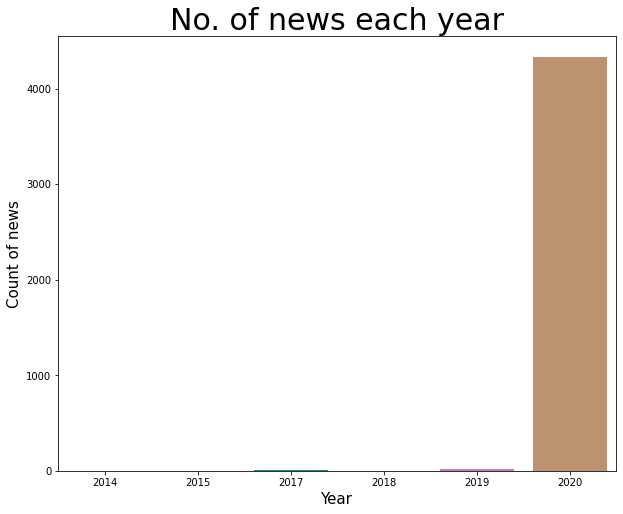

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['year'], palette ='colorblind')
plt.title('No. of news each year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of news', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


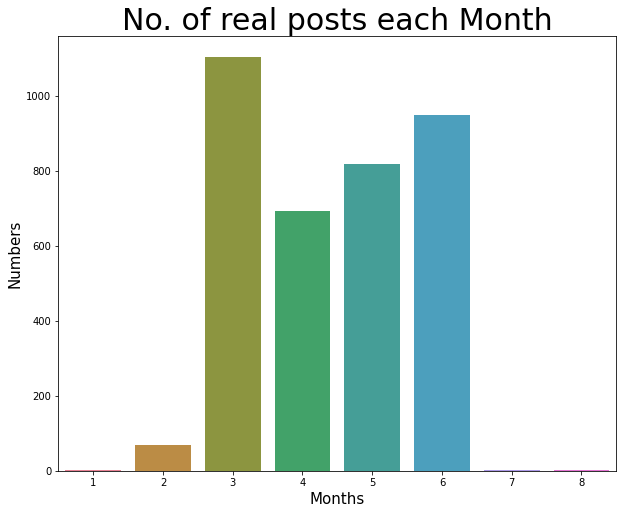

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['month'][data_train["label"] == 0], palette ='husl')
plt.title('No. of real posts each Month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Numbers', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


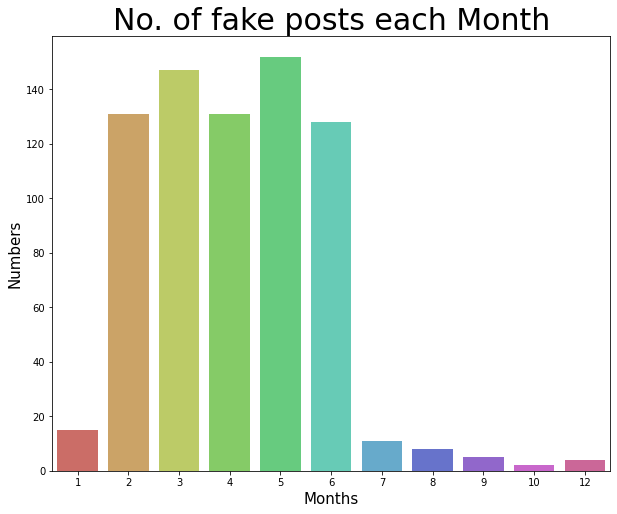

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['month'][data_train["label"] == 1], palette ='hls')
plt.title('No. of fake posts each Month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Numbers', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


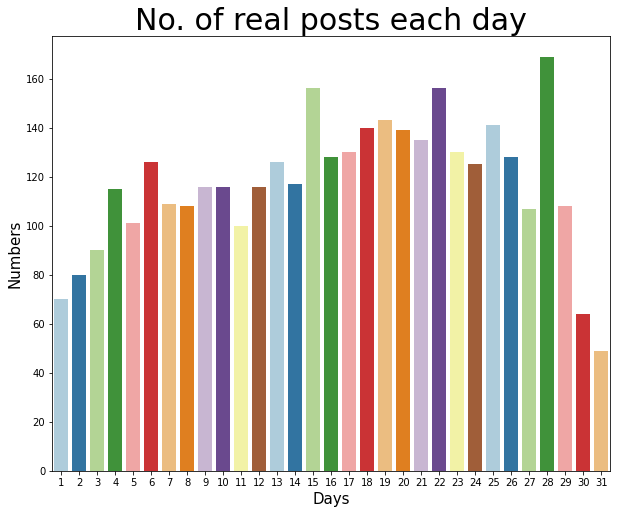

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['day'][data_train["label"] == 0], palette ='Paired')
plt.title('No. of real posts each day', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Numbers', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


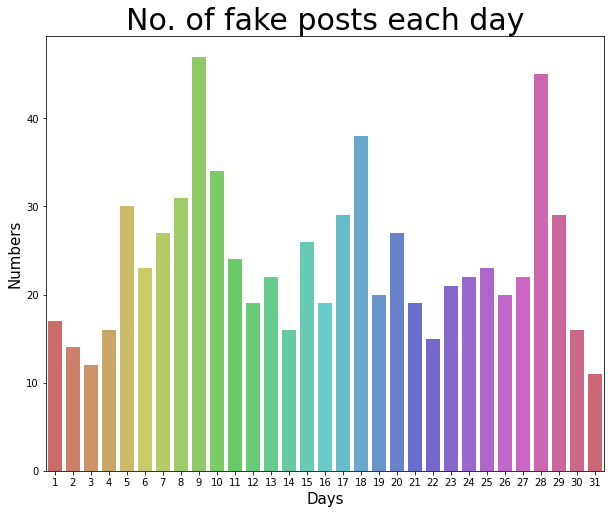

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['day'][data_train["label"] == 1], palette ='hls')
plt.title('No. of fake posts each day', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Numbers', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


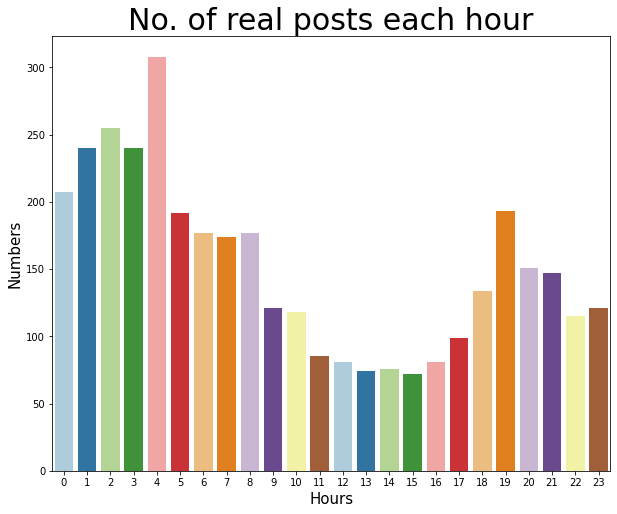

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['hour'][data_train["label"] == 0], palette ='Paired')
plt.title('No. of real posts each hour', fontsize = 30)
plt.xlabel('Hours', fontsize = 15)
plt.ylabel('Numbers', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


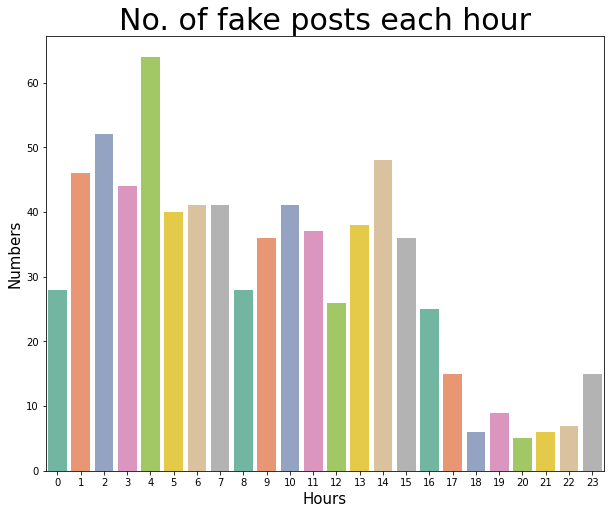

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(data_train['hour'][data_train["label"] == 1], palette ='Set2')
plt.title('No. of fake posts each hour', fontsize = 30)
plt.xlabel('Hours', fontsize = 15)
plt.ylabel('Numbers', fontsize = 15)
plt.show()

In [ ]:
user_reliable = data_train.loc[data_train['label'] == 0, :]['user_name'].value_counts()
user_unreliable = data_train.loc[data_train['label'] == 1, :]['user_name'].value_counts()

In [ ]:
import lightgbm
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
numerical_train = data_train.drop(columns=["id", "user_name", "post_message"])

In [ ]:
numerical_train['num_comment_post'] = numerical_train['num_comment_post'].astype("int")
numerical_train['num_like_post'] = numerical_train['num_like_post'].astype("int")
numerical_train['num_share_post'] = numerical_train['num_share_post'].astype("int")

In [ ]:
from scipy.stats import zscore
z_scores = zscore(numerical_train)
abs_z_scores = abs(z_scores)
filter_entries = (abs_z_scores <= 3).all(axis=1)

In [ ]:
numerical_train = numerical_train[filter_entries]

In [ ]:
X_train_numeric = numerical_train.drop(columns="label")
y_train = data_train['label']
y_train = y_train[filter_entries]
lightGBM_clf = LGBMClassifier()
lightGBM_model = lightGBM_clf.fit(X_train_numeric, y_train)

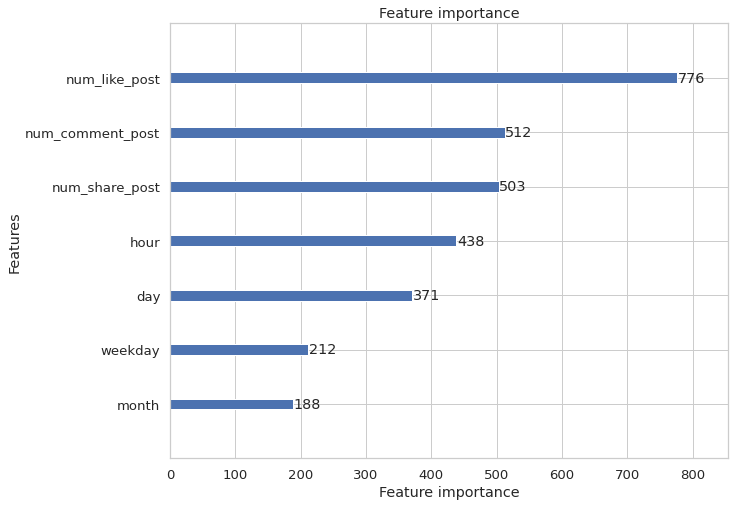

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
sns.set(style = 'whitegrid', font_scale = 1.2)
lightgbm.plot_importance(lightGBM_model)

Feature Importances :  [0.1979646  0.19361857 0.07727612 0.0444521  0.3166889  0.
 0.04474117 0.12525854]


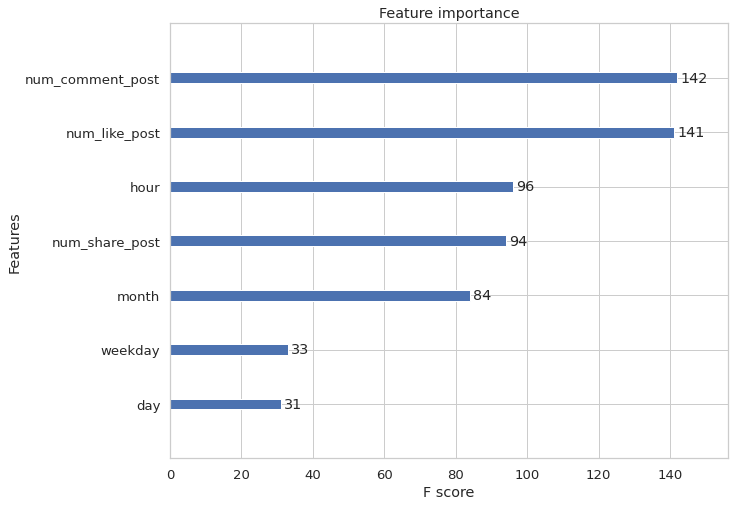

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train_numeric, y_train)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


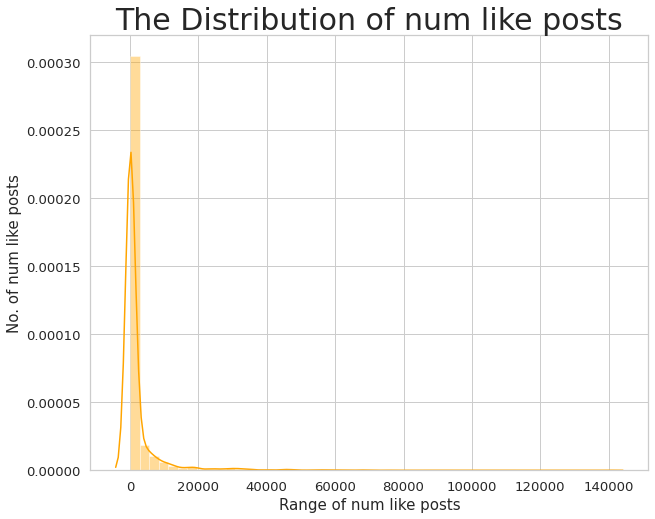

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(numerical_train['num_like_post'], color = 'orange')
plt.title('The Distribution of num like posts', fontsize = 30)
plt.xlabel('Range of num like posts', fontsize = 15)
plt.ylabel('No. of num like posts', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


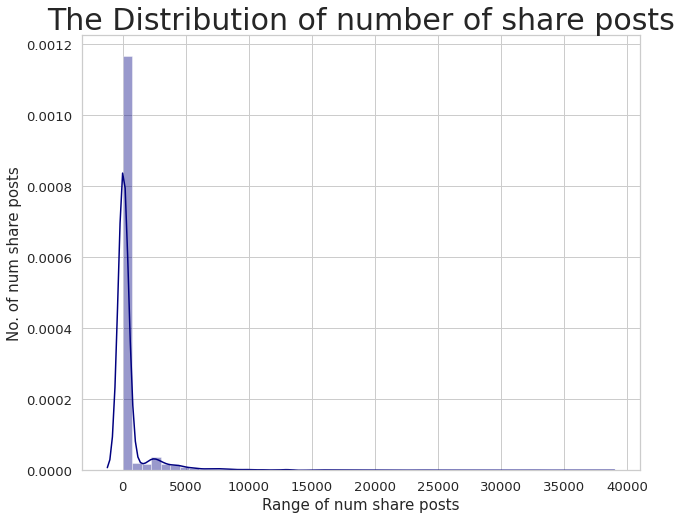

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(numerical_train['num_share_post'], color = 'navy')
plt.title('The Distribution of number of share posts', fontsize = 30)
plt.xlabel('Range of num share posts', fontsize = 15)
plt.ylabel('No. of num share posts', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


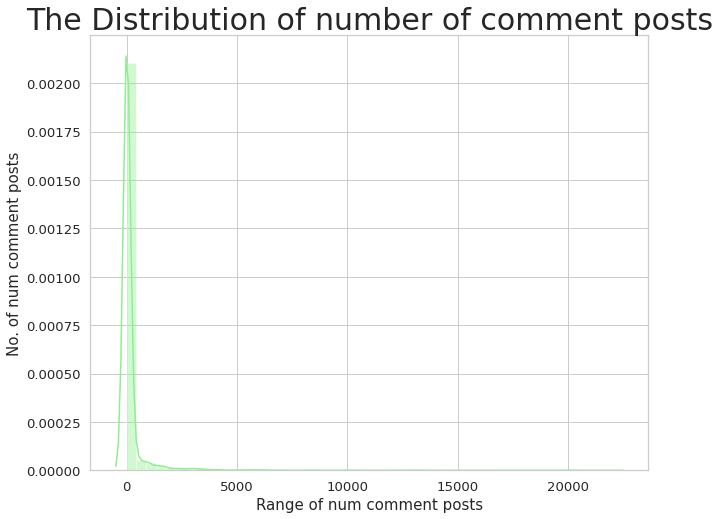

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(numerical_train['num_comment_post'], color = 'lightgreen')
plt.title('The Distribution of number of comment posts', fontsize = 30)
plt.xlabel('Range of num comment posts', fontsize = 15)
plt.ylabel('No. of num comment posts', fontsize = 15)
plt.show()

In [ ]:
outliers_list = np.where(filter_entries == False)[0]
outliers_list

array([  35,   81,  177,  285,  388,  591,  702,  782, 1417, 1534, 1557,
       1712, 1797, 1923, 1924, 1943, 2100, 2195, 2198, 2215, 2351, 2564,
       2592, 2637, 2652, 2711, 2719, 2726, 2919, 3066, 3133, 3172, 3178,
       3256, 3358, 3365, 3381, 3490, 3538, 3701, 3810, 3877, 3901, 3912,
       4149, 4219, 4323])

In [ ]:
numerical_train = numerical_train.drop(columns="year")
X_train_numeric = X_train_numeric.drop(columns="year")

In [ ]:
X_train_numeric

,num_like_post,num_comment_post,num_share_post,day,month,weekday,hour
0,19477,378,173,3,4,4,20
1,11,5,3,8,5,4,11
2,48,5,19,6,6,5,1
3,3,0,0,13,6,5,4
4,775,0,54,9,3,0,7
...,...,...,...,...,...,...,...
4367,5800,1300,12000,21,3,5,12
4368,21,1,87,28,5,3,6
4369,3,1,87,18,5,0,4
4370,144,38,87,15,5,4,14


In [ ]:
scaler = MinMaxScaler()
X_train_numeric[['num_like_post', 'num_share_post', 'num_comment_post']] = scaler.fit_transform(X_train_numeric[['num_like_post', 'num_share_post', 'num_comment_post']])

In [ ]:
filter_idxs = np.where(filter_entries == True)[0]
sentences_filter = data_train['post_message'][filter_entries].tolist()
sents_filter = [normalizePost(txt, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only", 512) for txt in sentences_filter]
X_train = X_train_numeric.copy(deep=True)
X_train['sentences'] = sents_filter

In [ ]:
# cv = CountVectorizer()
# tfidf_vec = TfidfVectorizer()
# tfidf_transformer = TfidfTransformer()

In [ ]:
X_test_numeric = data_test.drop(columns=["id", "user_name", "post_message", "timestamp_post", "year"])
X_test_numeric[['num_like_post', 'num_share_post', 'num_comment_post']] = scaler.fit_transform(X_test_numeric[['num_like_post', 'num_share_post', 'num_comment_post']])

In [ ]:
X_train_numeric

,num_like_post,num_comment_post,num_share_post,day,month,weekday,hour
0,0.139121,0.017182,0.004579,3,4,4,20
1,0.000079,0.000227,0.000079,8,5,4,11
2,0.000343,0.000227,0.000503,6,6,5,1
3,0.000021,0.000000,0.000000,13,6,5,4
4,0.005536,0.000000,0.001429,9,3,0,7
...,...,...,...,...,...,...,...
4367,0.041429,0.059091,0.317603,21,3,5,12
4368,0.000150,0.000045,0.002303,28,5,3,6
4369,0.000021,0.000045,0.002303,18,5,0,4
4370,0.001029,0.001727,0.002303,15,5,4,14


In [ ]:
numeric_model = xgb_model.fit(X_train_numeric, y_train)
xgb_num_prediction = numeric_model.predict_proba(X_test_numeric)
prediction = xgb_num_prediction[:, 0].tolist()
test_id = data_test['id'].tolist()

In [ ]:
final_result = []
for id, pred in zip(test_id, prediction):
  final_result.append([id, pred])

In [ ]:
result_df = DataFrame(final_result)
result_df.to_csv('/content/drive/MyDrive/VLSP-Fake-News-Detection/results.csv', index=False)